In [1]:
# =====================================================================
# Step 1: Imports and Path Setup
# ---------------------------------------------------------------------
# Objectives:
#   1. Load the preprocessed data artifacts from Pipeline 1.
#   2. Prepare directories for saving engineered feature outputs.
# =====================================================================

import numpy as np
import pandas as pd
import joblib
import json
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# Define core directories
ROOT = Path(".").resolve()
DATA_DIR = ROOT / "BODMAS"
ART_DIR = ROOT / "artifacts"
ART_DIR.mkdir(parents=True, exist_ok=True)

# Verify that artifacts exist before proceeding
required_files = ["Xy_splits.npz", "scaler.joblib", "splits.json", "eda.json"]
missing = [f for f in required_files if not (ART_DIR / f).exists()]
if missing:
    raise FileNotFoundError(f"Missing required artifact(s): {missing}")

print("Environment ready. Artifacts directory verified:", ART_DIR)

Environment ready. Artifacts directory verified: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/artifacts


In [2]:
# =====================================================================
# Step 2: Load preprocessed data and split indices
# ---------------------------------------------------------------------
# This loads:
#   - Full feature matrix (X) and label vector (y)
#   - Split indices for train/validation/test
#   - Fitted StandardScaler for later use if needed
# =====================================================================

# Load arrays and splits
npz = np.load(ART_DIR / "Xy_splits.npz")
X, y = npz["X"], npz["y"]
idx_train, idx_val, idx_test = npz["idx_train"], npz["idx_val"], npz["idx_test"]

# Load scaler
scaler = joblib.load(ART_DIR / "scaler.joblib")

print("Loaded data:")
print(f"  Feature matrix shape: {X.shape}")
print(f"  Label vector shape:   {y.shape}")
print(f"  Train / Val / Test:   {len(idx_train)} / {len(idx_val)} / {len(idx_test)}")

Loaded data:
  Feature matrix shape: (130716, 2381)
  Label vector shape:   (130716,)
  Train / Val / Test:   91501 / 19608 / 19607


In [3]:
# =====================================================================
# Step 3: Define feature engineering functions
# ---------------------------------------------------------------------
# Objective:
#   Create new derived features from behavioral indicators to enrich
#   the model’s representation of malware dynamics.
#
# Example engineered features:
#   - api_success_ratio: ratio of successful to failed API calls
#   - network_file_ratio: relationship between network and file ops
#   - behavior_hash: compressed hash representation of high-variance signals
# =====================================================================

def engineer_behavioral_features(X_block: np.ndarray) -> pd.DataFrame:
    """
    Generate engineered dynamic features from numeric feature matrix.
    
    Parameters
    ----------
    X_block : np.ndarray
        Input feature array (samples × features).

    Returns
    -------
    pd.DataFrame
        Engineered feature DataFrame.
    """
    df = pd.DataFrame(X_block)

    # Example engineered ratios — adjust feature indices based on documentation
    df["api_success_ratio"] = (df[10] + 1) / (df[11] + 1)
    df["network_file_ratio"] = (df[100] + 1) / (df[50] + 1)

    # Example behavioral hash: binary pattern hash of top-variance features
    topk = np.argsort(-np.var(X_block, axis=0))[:64]
    signature = (X_block[:, topk] > X_block[:, topk].mean(axis=0)).astype(int)
    df["behavior_hash"] = (signature * (1 << np.arange(signature.shape[1]))).sum(axis=1) % 1024

    return df
print("Done")

Done


In [8]:
# =====================================================================
# Step 4: Apply feature engineering functions to each dataset split
# ---------------------------------------------------------------------
# Objective:
#   1. Engineer new features independently per split.
#   2. Concatenate original features with engineered ones safely.
#   3. Assign clear feature names to avoid duplicate columns.
# =====================================================================

def build_enhanced_features(X, indices):
    """Return concatenated [original + engineered] feature matrix with unique names."""
    # Create DataFrame with labeled original features
    base = pd.DataFrame(X[indices])
    base.columns = [f"f_{i}" for i in range(base.shape[1])]  # unique labels like f_0, f_1, ...
    
    # Generate engineered features
    engineered = engineer_behavioral_features(X[indices])
    
    # Combine and return
    enhanced = pd.concat([base, engineered], axis=1)
    return enhanced

# Apply transformation per subset
X_train_enh = build_enhanced_features(X, idx_train)
X_val_enh   = build_enhanced_features(X, idx_val)
X_test_enh  = build_enhanced_features(X, idx_test)

print("Enhanced feature sets created successfully:")
print(f"  Train shape: {X_train_enh.shape}")
print(f"  Val shape:   {X_val_enh.shape}")
print(f"  Test shape:  {X_test_enh.shape}")
print(f"  Example columns: {list(X_train_enh.columns[-5:])}")

Enhanced feature sets created successfully:
  Train shape: (91501, 4765)
  Val shape:   (19608, 4765)
  Test shape:  (19607, 4765)
  Example columns: [2379, 2380, 'api_success_ratio', 'network_file_ratio', 'behavior_hash']


In [9]:
# =====================================================================
# Step 5: Inspect engineered feature distributions
# ---------------------------------------------------------------------
# Objective:
#   Perform a quick statistical overview of new features to ensure
#   numeric validity and absence of extreme outliers.
# =====================================================================

feature_subset = ["api_success_ratio", "network_file_ratio", "behavior_hash"]

summary_stats = X_train_enh[feature_subset].describe().T
print("Summary statistics for engineered features:\n")
print(summary_stats)

Summary statistics for engineered features:

                      count       mean        std       min       25%  \
api_success_ratio   91501.0   1.001331   0.005385  0.910671  0.999977   
network_file_ratio  91501.0   0.999729   0.011118  0.840848  1.000007   
behavior_hash       91501.0  11.565480  46.129813  0.000000  0.000000   

                         50%       75%          max  
api_success_ratio   1.000093  1.000741     1.300294  
network_file_ratio  1.000467  1.002131     1.127047  
behavior_hash       1.000000  1.000000  1023.000000  


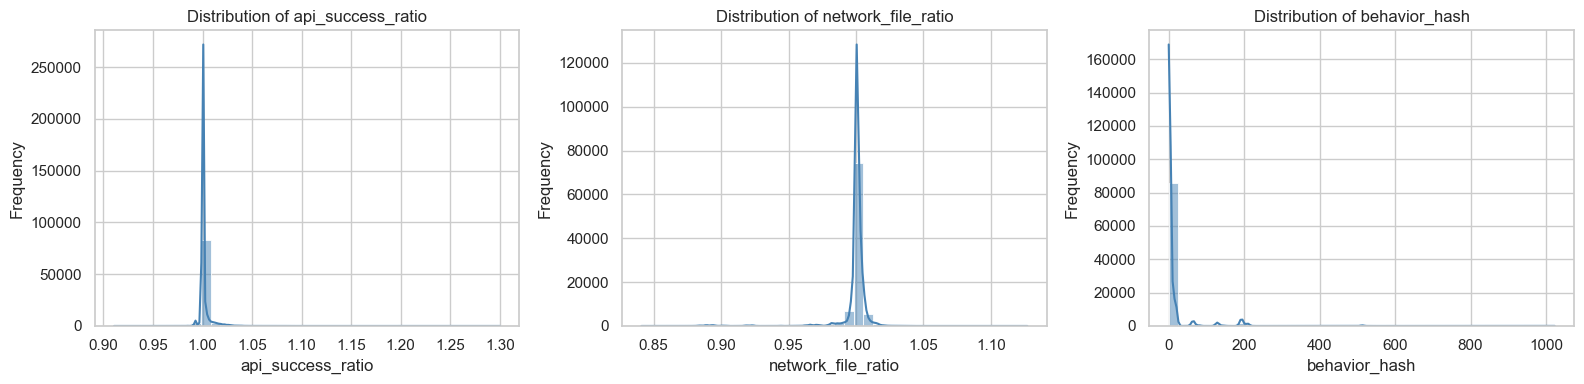

In [10]:
# =====================================================================
# Step 6: Visualize engineered feature distributions
# ---------------------------------------------------------------------
# Objectives:
#   1. Plot histograms to verify scale and variation of engineered features.
#   2. Check that no feature dominates numerically.
# =====================================================================

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, col in zip(axes, feature_subset):
    sns.histplot(X_train_enh[col], bins=40, color="steelblue", ax=ax, kde=True)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [12]:
# =====================================================================
# Step 7: Save enhanced feature matrices for downstream modeling
# ---------------------------------------------------------------------
# Objectives:
#   1. Persist train/val/test feature sets with engineered columns.
#   2. Allow baseline and engineered models to be compared later.
# =====================================================================
# Convert column names to strings for Parquet compatibility
X_train_enh.columns = X_train_enh.columns.astype(str)
X_val_enh.columns   = X_val_enh.columns.astype(str)
X_test_enh.columns  = X_test_enh.columns.astype(str)

# Save the files
X_train_enh.to_parquet(ART_DIR / "X_train_enh.parquet")
X_val_enh.to_parquet(ART_DIR / "X_val_enh.parquet")
X_test_enh.to_parquet(ART_DIR / "X_test_enh.parquet")

print("Enhanced feature matrices saved to artifacts/:")
for f in ART_DIR.glob("X_*_enh.parquet"):
    print(" -", f.name)

Enhanced feature matrices saved to artifacts/:
 - X_train_enh.parquet
 - X_test_enh.parquet
 - X_val_enh.parquet
